In [1]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy.fuzzy_layer import FuzzyLayer


In [2]:
batch_size = 256
learning_rate = 2e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 2
fuzzy_dim = 2
beta = 1
gamma = 1 
fuzzy_labels = 10 #10 numbers 
unknown_classes_ratio = 0.0 # unknow samples rate
is_fuzzy_loss_active = False

prefix = "vae"
if is_fuzzy_loss_active:
    prefix = f"fuzzy_cvae_with_unknown_ratio_{unknown_classes_ratio}"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if is_fuzzy_loss_active:
    gamma = 1
else:
    gamma = 0

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [4]:
def get_target_and_mask(target_label, unknown_ratio):
    """
    Возвращает вектор целевого значения и маску в виде сдвоенного тензора

    Args:
        target_label (int): Метка класса
        unknown_ratio (float): Доля примеров в датасете, чья разметка будет игнорироваться при обучении
    
    Returns:
        tensor (2, 12)
    """
    t = F.one_hot(torch.LongTensor([target_label]), fuzzy_labels)
    m = torch.ones((1, fuzzy_labels)) if torch.rand(1) > unknown_ratio else torch.zeros((1, fuzzy_labels))
    
    return torch.cat((t, m), 0).to(device) 

In [5]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x,unknown_classes_ratio))
)

In [6]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x, 0))
)
len(test_data)

10000

In [7]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [8]:
class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(8, 16, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(16, 32, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.SiLU(),  
            nn.Flatten(),
            nn.Linear(9216, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(),  
            nn.Linear(625, 2 * latent_dim), # mean + variance.
        )
        self.softplus = nn.Softplus()
         
    def forward(self, x, eps: float = 1e-8):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """

        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        dist = torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        z = dist.rsample()

        return mu, logvar, z

In [9]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
                
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(), 
            nn.Linear(625, 9216),
            nn.BatchNorm1d(9216),
            nn.SiLU(), 
            nn.Unflatten(1,(64, 12, 12)),
            nn.ConvTranspose2d(64, 32, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(32, 16, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(16, 8, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(8, 1, 5),
            nn.Sigmoid() 
        )
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """

        x = self.decoder(z)
        
        return x

In [10]:
class CVAE(nn.Module):
    """
    Conditional Variational Autoencoder (C-VAE) 
    
    Args:
        latent_dim (int): Размер латентного вектора.
        labels_count (int): Количество выходов классификатора
    """
    def __init__(self, latent_dim, labels_count, fuzzy_dim):
        super(CVAE, self).__init__()

        self.encoder = Encoder(latent_dim)        
        self.decoder = Decoder(latent_dim)
        self.fuzzy_dim = fuzzy_dim
        self.fuzzy = nn.Sequential(
            FuzzyLayer.fromdimentions(fuzzy_dim, labels_count, trainable=True)
        )
        
        
    def forward(self, x):
        """
        Возвращает компоненты внутренних слоев CVAE, результаты реконструкции и классификации
        
        Args:
            x (torch.Tensor): Входной вектор.
        
        Returns:
            mu, x_recon, labels
        """

        mu, _,  _, = self.encoder(x)
        x_recon = self.decoder(mu)
        
        labels = self.fuzzy(mu[:, 0:self.fuzzy_dim])

        return mu, x_recon, labels
    
    def half_pass(self, x):
        """
        Возвращает результаты работы энкодера и классификатора
        """
        mu, logvar, z = self.encoder(x)
        labels = self.fuzzy(mu[:, 0:self.fuzzy_dim])

        return mu, logvar, z, labels
    
    def decoder_pass(self, x):
        return self.decoder(x)


In [11]:
def compute_loss(x, recon_x, mu, logvar, z, target_labels, predicted_labels):
    
    loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
    
    tsquare = torch.square(mu)
    tlogvar = torch.exp(logvar)
    kl_loss = -0.5 * (1 + logvar - tsquare - tlogvar)
    loss_kl = kl_loss.sum(-1).mean()
            
    target_firings = target_labels[:,0,:]
    mask = target_labels[:,1,:]
    loss_fuzzy = (mask * torch.square(target_firings - predicted_labels)).sum(-1).mean()

    loss = loss_recon + beta * loss_kl + gamma * loss_fuzzy

    

    return loss, loss_recon, loss_kl, loss_fuzzy
    

In [12]:
model = CVAE(latent_dim=latent_dim, labels_count=fuzzy_labels, fuzzy_dim=fuzzy_dim).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 11,690,317


CVAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): SiLU()
      (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
      (3): SiLU()
      (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (5): SiLU()
      (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): SiLU()
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=9216, out_features=625, bias=True)
      (11): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): SiLU()
      (13): Linear(in_features=625, out_features=4, bias=True)
    )
    (softplus): Softplus(beta=1, threshold=20)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=625, bias=True)
      (1): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [14]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    model.train()  
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  
        
        mu, logcar, z, labels = model.half_pass(data)  
        recon_x = model.decoder_pass(z)
        loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z, target, labels)
        
        loss.backward()
        
        if n_upd % 100 == 0:
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {loss_recon.item():.4f}, KL: {loss_kl.item():.4f} Fuzzy: {loss_fuzzy.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', loss_kl.item(), global_step)
                writer.add_scalar('Fuzzy/Train/Loss', loss_fuzzy.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  
        
    return prev_updates + len(dataloader)

In [15]:
def test(model, dataloader, cur_step, writer=None):
    model.eval() 
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    test_fuzzy_loss = 0
    test_accuracy = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            mu, logcar, z, labels = model.half_pass(data)  
            recon_x = model.decoder_pass(z)
            loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z,  target, labels)
            
            test_loss += loss.item()
            test_recon_loss += loss_recon.item()
            test_kl_loss += loss_kl.item()
            test_fuzzy_loss += loss_fuzzy.item()
            pred_target = np.argmax(labels[:, 0:10].cpu().numpy(), axis=1)
            target_labels =  np.argmax(target[:,0, 0:10].cpu().numpy(), axis=1)
            test_accuracy += np.sum(target_labels==pred_target) / len(pred_target)

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    test_fuzzy_loss /= len(dataloader)
    test_accuracy /= len(dataloader)

    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f} Fuzzy: {test_fuzzy_loss:.4f} Accuracy {test_accuracy:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', loss_kl.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Loss', loss_fuzzy.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Accuracy', test_accuracy, global_step=cur_step)
        
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decoder_pass(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [16]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)


Epoch 1/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 0 (N samples: 0), Loss: 21.2846 (Recon: 21.0978, KL: 0.1868 Fuzzy: 1.4330) Grad: 13.6031
Step 100 (N samples: 25,600), Loss: 7.7427 (Recon: 7.3969, KL: 0.3458 Fuzzy: 1.3907) Grad: 17.7178
Step 200 (N samples: 51,200), Loss: 7.1336 (Recon: 6.5376, KL: 0.5960 Fuzzy: 1.4093) Grad: 5.3186


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2103 (BCE: 6.6501, KLD: 0.5601 Fuzzy: 1.4285 Accuracy 0.1148)
Epoch 2/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 300 (N samples: 76,800), Loss: 7.1197 (Recon: 6.4080, KL: 0.7117 Fuzzy: 1.4438) Grad: 3.6570
Step 400 (N samples: 102,400), Loss: 7.1959 (Recon: 6.5537, KL: 0.6422 Fuzzy: 1.3616) Grad: 3.8259


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2937 (BCE: 6.3789, KLD: 0.9148 Fuzzy: 1.3887 Accuracy 0.1049)
Epoch 3/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 500 (N samples: 128,000), Loss: 7.0765 (Recon: 6.3168, KL: 0.7596 Fuzzy: 1.4120) Grad: 3.9579
Step 600 (N samples: 153,600), Loss: 6.9737 (Recon: 6.2528, KL: 0.7209 Fuzzy: 1.4337) Grad: 2.2239
Step 700 (N samples: 179,200), Loss: 7.1421 (Recon: 6.4208, KL: 0.7214 Fuzzy: 1.4053) Grad: 2.7750


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1518 (BCE: 6.2183, KLD: 0.9336 Fuzzy: 1.3905 Accuracy 0.1104)
Epoch 4/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 800 (N samples: 204,800), Loss: 6.9936 (Recon: 6.2564, KL: 0.7371 Fuzzy: 1.4268) Grad: 3.1377
Step 900 (N samples: 230,400), Loss: 6.8217 (Recon: 6.0912, KL: 0.7305 Fuzzy: 1.4600) Grad: 2.1634


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0233 (BCE: 6.2657, KLD: 0.7575 Fuzzy: 1.4372 Accuracy 0.1262)
Epoch 5/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,000 (N samples: 256,000), Loss: 7.0964 (Recon: 6.3028, KL: 0.7935 Fuzzy: 1.4646) Grad: 2.5699
Step 1,100 (N samples: 281,600), Loss: 7.0474 (Recon: 6.2691, KL: 0.7782 Fuzzy: 1.4497) Grad: 1.4782


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0424 (BCE: 6.3403, KLD: 0.7021 Fuzzy: 1.4518 Accuracy 0.1207)
Epoch 6/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,200 (N samples: 307,200), Loss: 6.9808 (Recon: 6.1732, KL: 0.8076 Fuzzy: 1.4683) Grad: 2.0241
Step 1,300 (N samples: 332,800), Loss: 6.9933 (Recon: 6.2053, KL: 0.7880 Fuzzy: 1.4089) Grad: 1.5765
Step 1,400 (N samples: 358,400), Loss: 7.0658 (Recon: 6.2662, KL: 0.7996 Fuzzy: 1.4332) Grad: 1.5297


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9891 (BCE: 6.1577, KLD: 0.8314 Fuzzy: 1.4290 Accuracy 0.1354)
Epoch 7/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,500 (N samples: 384,000), Loss: 7.1378 (Recon: 6.2932, KL: 0.8446 Fuzzy: 1.4339) Grad: 1.7872
Step 1,600 (N samples: 409,600), Loss: 6.9862 (Recon: 6.1846, KL: 0.8016 Fuzzy: 1.3822) Grad: 1.7991


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9822 (BCE: 6.2009, KLD: 0.7813 Fuzzy: 1.4438 Accuracy 0.1410)
Epoch 8/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,700 (N samples: 435,200), Loss: 7.1418 (Recon: 6.3305, KL: 0.8114 Fuzzy: 1.4384) Grad: 2.6207
Step 1,800 (N samples: 460,800), Loss: 6.9872 (Recon: 6.1742, KL: 0.8130 Fuzzy: 1.3967) Grad: 1.2410


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0160 (BCE: 6.2009, KLD: 0.8151 Fuzzy: 1.4347 Accuracy 0.1464)
Epoch 9/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,900 (N samples: 486,400), Loss: 7.1136 (Recon: 6.2142, KL: 0.8993 Fuzzy: 1.4151) Grad: 1.1189
Step 2,000 (N samples: 512,000), Loss: 7.0951 (Recon: 6.2354, KL: 0.8597 Fuzzy: 1.4104) Grad: 1.7182
Step 2,100 (N samples: 537,600), Loss: 6.8169 (Recon: 5.9758, KL: 0.8411 Fuzzy: 1.4511) Grad: 2.3095


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9930 (BCE: 6.1287, KLD: 0.8644 Fuzzy: 1.4258 Accuracy 0.1472)
Epoch 10/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,200 (N samples: 563,200), Loss: 6.9614 (Recon: 6.1144, KL: 0.8470 Fuzzy: 1.4222) Grad: 1.2657
Step 2,300 (N samples: 588,800), Loss: 6.9841 (Recon: 6.1556, KL: 0.8285 Fuzzy: 1.4674) Grad: 1.8789


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0115 (BCE: 6.1429, KLD: 0.8687 Fuzzy: 1.4430 Accuracy 0.1517)
Epoch 11/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,400 (N samples: 614,400), Loss: 7.1158 (Recon: 6.2289, KL: 0.8870 Fuzzy: 1.3818) Grad: 1.8189
Step 2,500 (N samples: 640,000), Loss: 6.8309 (Recon: 6.0078, KL: 0.8231 Fuzzy: 1.4668) Grad: 1.0411


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9587 (BCE: 6.0764, KLD: 0.8823 Fuzzy: 1.4448 Accuracy 0.1530)
Epoch 12/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,600 (N samples: 665,600), Loss: 6.9672 (Recon: 6.0588, KL: 0.9083 Fuzzy: 1.4333) Grad: 1.1932
Step 2,700 (N samples: 691,200), Loss: 6.8644 (Recon: 6.0230, KL: 0.8414 Fuzzy: 1.5006) Grad: 1.2768
Step 2,800 (N samples: 716,800), Loss: 6.9804 (Recon: 6.1571, KL: 0.8233 Fuzzy: 1.4155) Grad: 1.5971


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9458 (BCE: 6.0970, KLD: 0.8488 Fuzzy: 1.4686 Accuracy 0.1647)
Epoch 13/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,900 (N samples: 742,400), Loss: 6.7861 (Recon: 5.9285, KL: 0.8575 Fuzzy: 1.5006) Grad: 1.5840
Step 3,000 (N samples: 768,000), Loss: 6.7531 (Recon: 5.8762, KL: 0.8769 Fuzzy: 1.4748) Grad: 1.2896


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9578 (BCE: 6.0874, KLD: 0.8704 Fuzzy: 1.4829 Accuracy 0.1640)
Epoch 14/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,100 (N samples: 793,600), Loss: 6.9219 (Recon: 6.0132, KL: 0.9087 Fuzzy: 1.4376) Grad: 2.0388
Step 3,200 (N samples: 819,200), Loss: 6.9223 (Recon: 6.0514, KL: 0.8708 Fuzzy: 1.4456) Grad: 1.8101


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9962 (BCE: 5.9587, KLD: 1.0374 Fuzzy: 1.4230 Accuracy 0.1599)
Epoch 15/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,300 (N samples: 844,800), Loss: 6.8308 (Recon: 5.9590, KL: 0.8718 Fuzzy: 1.4875) Grad: 1.1922
Step 3,400 (N samples: 870,400), Loss: 6.8544 (Recon: 5.9334, KL: 0.9210 Fuzzy: 1.4645) Grad: 1.2398
Step 3,500 (N samples: 896,000), Loss: 6.9996 (Recon: 6.1381, KL: 0.8615 Fuzzy: 1.4281) Grad: 2.0090


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9270 (BCE: 6.0229, KLD: 0.9041 Fuzzy: 1.4743 Accuracy 0.1622)
Epoch 16/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,600 (N samples: 921,600), Loss: 7.0833 (Recon: 6.1593, KL: 0.9240 Fuzzy: 1.4357) Grad: 1.3450
Step 3,700 (N samples: 947,200), Loss: 7.0353 (Recon: 6.1451, KL: 0.8901 Fuzzy: 1.4866) Grad: 1.4724


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9481 (BCE: 6.0183, KLD: 0.9298 Fuzzy: 1.4829 Accuracy 0.1576)
Epoch 17/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,800 (N samples: 972,800), Loss: 6.8046 (Recon: 5.8695, KL: 0.9351 Fuzzy: 1.4724) Grad: 1.5086
Step 3,900 (N samples: 998,400), Loss: 7.0292 (Recon: 6.0773, KL: 0.9518 Fuzzy: 1.5271) Grad: 1.1197


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9518 (BCE: 6.0258, KLD: 0.9260 Fuzzy: 1.4692 Accuracy 0.1685)
Epoch 18/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,000 (N samples: 1,024,000), Loss: 7.1084 (Recon: 6.1923, KL: 0.9161 Fuzzy: 1.4907) Grad: 1.1293
Step 4,100 (N samples: 1,049,600), Loss: 6.8600 (Recon: 5.8773, KL: 0.9827 Fuzzy: 1.4494) Grad: 0.9792
Step 4,200 (N samples: 1,075,200), Loss: 6.8546 (Recon: 5.9207, KL: 0.9340 Fuzzy: 1.5148) Grad: 0.8861


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9339 (BCE: 5.9998, KLD: 0.9341 Fuzzy: 1.4929 Accuracy 0.1652)
Epoch 19/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,300 (N samples: 1,100,800), Loss: 7.0107 (Recon: 6.0849, KL: 0.9259 Fuzzy: 1.4480) Grad: 1.2867
Step 4,400 (N samples: 1,126,400), Loss: 6.9081 (Recon: 5.9764, KL: 0.9318 Fuzzy: 1.4786) Grad: 1.1742


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9747 (BCE: 6.0454, KLD: 0.9293 Fuzzy: 1.4925 Accuracy 0.1821)
Epoch 20/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,500 (N samples: 1,152,000), Loss: 6.9055 (Recon: 5.9087, KL: 0.9968 Fuzzy: 1.4989) Grad: 0.8316
Step 4,600 (N samples: 1,177,600), Loss: 7.0873 (Recon: 6.0999, KL: 0.9874 Fuzzy: 1.4737) Grad: 1.5671


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9199 (BCE: 5.9859, KLD: 0.9340 Fuzzy: 1.5085 Accuracy 0.1709)
Epoch 21/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,700 (N samples: 1,203,200), Loss: 6.9898 (Recon: 6.0122, KL: 0.9776 Fuzzy: 1.4538) Grad: 1.2082
Step 4,800 (N samples: 1,228,800), Loss: 6.9593 (Recon: 6.0168, KL: 0.9425 Fuzzy: 1.4582) Grad: 1.8533
Step 4,900 (N samples: 1,254,400), Loss: 7.1679 (Recon: 6.2463, KL: 0.9217 Fuzzy: 1.4917) Grad: 1.5653


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9490 (BCE: 5.9291, KLD: 1.0199 Fuzzy: 1.4545 Accuracy 0.1762)
Epoch 22/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,000 (N samples: 1,280,000), Loss: 7.1330 (Recon: 6.1563, KL: 0.9767 Fuzzy: 1.4033) Grad: 1.1713
Step 5,100 (N samples: 1,305,600), Loss: 7.0894 (Recon: 6.1434, KL: 0.9460 Fuzzy: 1.5075) Grad: 1.2654


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9245 (BCE: 5.9050, KLD: 1.0196 Fuzzy: 1.4654 Accuracy 0.1688)
Epoch 23/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,200 (N samples: 1,331,200), Loss: 7.1561 (Recon: 6.1447, KL: 1.0113 Fuzzy: 1.5195) Grad: 1.9158
Step 5,300 (N samples: 1,356,800), Loss: 6.9603 (Recon: 5.9979, KL: 0.9623 Fuzzy: 1.5223) Grad: 1.8383
Step 5,400 (N samples: 1,382,400), Loss: 6.9947 (Recon: 6.0180, KL: 0.9767 Fuzzy: 1.4881) Grad: 1.3349


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9131 (BCE: 5.8660, KLD: 1.0471 Fuzzy: 1.4893 Accuracy 0.1653)
Epoch 24/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,500 (N samples: 1,408,000), Loss: 6.9429 (Recon: 5.9586, KL: 0.9843 Fuzzy: 1.4767) Grad: 0.7603
Step 5,600 (N samples: 1,433,600), Loss: 6.8432 (Recon: 5.8356, KL: 1.0076 Fuzzy: 1.5227) Grad: 1.1557


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9173 (BCE: 5.8945, KLD: 1.0228 Fuzzy: 1.5104 Accuracy 0.1635)
Epoch 25/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,700 (N samples: 1,459,200), Loss: 7.0252 (Recon: 6.0348, KL: 0.9905 Fuzzy: 1.5209) Grad: 1.2298
Step 5,800 (N samples: 1,484,800), Loss: 6.7502 (Recon: 5.7818, KL: 0.9684 Fuzzy: 1.5253) Grad: 1.1031


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9168 (BCE: 5.8672, KLD: 1.0496 Fuzzy: 1.4897 Accuracy 0.1623)
Epoch 26/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,900 (N samples: 1,510,400), Loss: 6.8170 (Recon: 5.8189, KL: 0.9981 Fuzzy: 1.5503) Grad: 1.1448
Step 6,000 (N samples: 1,536,000), Loss: 6.6912 (Recon: 5.6821, KL: 1.0091 Fuzzy: 1.5646) Grad: 1.5324
Step 6,100 (N samples: 1,561,600), Loss: 6.8577 (Recon: 5.8416, KL: 1.0161 Fuzzy: 1.5144) Grad: 0.9043


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8886 (BCE: 5.8396, KLD: 1.0490 Fuzzy: 1.5054 Accuracy 0.1641)
Epoch 27/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,200 (N samples: 1,587,200), Loss: 6.8800 (Recon: 5.8372, KL: 1.0428 Fuzzy: 1.4865) Grad: 0.9451
Step 6,300 (N samples: 1,612,800), Loss: 7.1679 (Recon: 6.1634, KL: 1.0044 Fuzzy: 1.5332) Grad: 1.9299


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8902 (BCE: 5.8891, KLD: 1.0011 Fuzzy: 1.5182 Accuracy 0.1699)
Epoch 28/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,400 (N samples: 1,638,400), Loss: 6.9322 (Recon: 5.8951, KL: 1.0371 Fuzzy: 1.5409) Grad: 1.2719
Step 6,500 (N samples: 1,664,000), Loss: 6.9722 (Recon: 5.9678, KL: 1.0044 Fuzzy: 1.5616) Grad: 1.0642


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9239 (BCE: 5.8499, KLD: 1.0740 Fuzzy: 1.5224 Accuracy 0.1635)
Epoch 29/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,600 (N samples: 1,689,600), Loss: 7.0339 (Recon: 5.9836, KL: 1.0503 Fuzzy: 1.5427) Grad: 1.3877
Step 6,700 (N samples: 1,715,200), Loss: 6.7636 (Recon: 5.7661, KL: 0.9975 Fuzzy: 1.5355) Grad: 1.0429
Step 6,800 (N samples: 1,740,800), Loss: 6.9774 (Recon: 5.9319, KL: 1.0455 Fuzzy: 1.5292) Grad: 0.8004


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8896 (BCE: 5.8650, KLD: 1.0246 Fuzzy: 1.5596 Accuracy 0.1680)
Epoch 30/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,900 (N samples: 1,766,400), Loss: 6.9234 (Recon: 5.8749, KL: 1.0485 Fuzzy: 1.5619) Grad: 0.8911
Step 7,000 (N samples: 1,792,000), Loss: 6.8968 (Recon: 5.8663, KL: 1.0305 Fuzzy: 1.5821) Grad: 1.0514


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8552 (BCE: 5.8254, KLD: 1.0298 Fuzzy: 1.5274 Accuracy 0.1647)
Epoch 31/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,100 (N samples: 1,817,600), Loss: 7.1271 (Recon: 6.0648, KL: 1.0623 Fuzzy: 1.5143) Grad: 1.1241
Step 7,200 (N samples: 1,843,200), Loss: 6.9439 (Recon: 5.9059, KL: 1.0381 Fuzzy: 1.5725) Grad: 0.7312


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8870 (BCE: 5.8034, KLD: 1.0836 Fuzzy: 1.5368 Accuracy 0.1633)
Epoch 32/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,300 (N samples: 1,868,800), Loss: 6.9136 (Recon: 5.8936, KL: 1.0200 Fuzzy: 1.5423) Grad: 0.8735
Step 7,400 (N samples: 1,894,400), Loss: 6.9531 (Recon: 5.9531, KL: 1.0000 Fuzzy: 1.5751) Grad: 0.8641
Step 7,500 (N samples: 1,920,000), Loss: 6.8182 (Recon: 5.7973, KL: 1.0208 Fuzzy: 1.5845) Grad: 0.8878


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8921 (BCE: 5.8194, KLD: 1.0727 Fuzzy: 1.5516 Accuracy 0.1600)
Epoch 33/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,600 (N samples: 1,945,600), Loss: 7.0479 (Recon: 6.0205, KL: 1.0275 Fuzzy: 1.5022) Grad: 1.3539
Step 7,700 (N samples: 1,971,200), Loss: 6.9984 (Recon: 5.9413, KL: 1.0571 Fuzzy: 1.5469) Grad: 0.9212


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8820 (BCE: 5.8279, KLD: 1.0541 Fuzzy: 1.5454 Accuracy 0.1697)
Epoch 34/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,800 (N samples: 1,996,800), Loss: 6.9180 (Recon: 5.8615, KL: 1.0565 Fuzzy: 1.5220) Grad: 0.6401
Step 7,900 (N samples: 2,022,400), Loss: 6.9632 (Recon: 5.9059, KL: 1.0573 Fuzzy: 1.6079) Grad: 0.9870


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8724 (BCE: 5.8640, KLD: 1.0084 Fuzzy: 1.5613 Accuracy 0.1652)
Epoch 35/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,000 (N samples: 2,048,000), Loss: 6.8586 (Recon: 5.8653, KL: 0.9934 Fuzzy: 1.5590) Grad: 0.9045
Step 8,100 (N samples: 2,073,600), Loss: 7.0809 (Recon: 6.0190, KL: 1.0619 Fuzzy: 1.5906) Grad: 1.8024
Step 8,200 (N samples: 2,099,200), Loss: 6.9033 (Recon: 5.8353, KL: 1.0680 Fuzzy: 1.5595) Grad: 1.5151


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8599 (BCE: 5.8528, KLD: 1.0071 Fuzzy: 1.5797 Accuracy 0.1593)
Epoch 36/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,300 (N samples: 2,124,800), Loss: 6.9387 (Recon: 5.8998, KL: 1.0389 Fuzzy: 1.5321) Grad: 1.0663
Step 8,400 (N samples: 2,150,400), Loss: 7.0781 (Recon: 6.0133, KL: 1.0649 Fuzzy: 1.5871) Grad: 2.1854


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8672 (BCE: 5.8172, KLD: 1.0500 Fuzzy: 1.5823 Accuracy 0.1615)
Epoch 37/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,500 (N samples: 2,176,000), Loss: 7.0514 (Recon: 5.9717, KL: 1.0797 Fuzzy: 1.5790) Grad: 1.0223
Step 8,600 (N samples: 2,201,600), Loss: 7.1353 (Recon: 6.0650, KL: 1.0704 Fuzzy: 1.5170) Grad: 1.0060


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8831 (BCE: 5.8423, KLD: 1.0408 Fuzzy: 1.5760 Accuracy 0.1638)
Epoch 38/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,700 (N samples: 2,227,200), Loss: 6.9283 (Recon: 5.9041, KL: 1.0242 Fuzzy: 1.5495) Grad: 1.5499
Step 8,800 (N samples: 2,252,800), Loss: 6.8343 (Recon: 5.7400, KL: 1.0944 Fuzzy: 1.5798) Grad: 0.7246
Step 8,900 (N samples: 2,278,400), Loss: 6.8336 (Recon: 5.7829, KL: 1.0507 Fuzzy: 1.5760) Grad: 1.0121


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8603 (BCE: 5.8178, KLD: 1.0425 Fuzzy: 1.5912 Accuracy 0.1661)
Epoch 39/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,000 (N samples: 2,304,000), Loss: 6.9276 (Recon: 5.8419, KL: 1.0857 Fuzzy: 1.5739) Grad: 1.0157
Step 9,100 (N samples: 2,329,600), Loss: 6.9063 (Recon: 5.8519, KL: 1.0543 Fuzzy: 1.6018) Grad: 1.0169


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8737 (BCE: 5.7980, KLD: 1.0758 Fuzzy: 1.5901 Accuracy 0.1640)
Epoch 40/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,200 (N samples: 2,355,200), Loss: 6.7834 (Recon: 5.6666, KL: 1.1168 Fuzzy: 1.6135) Grad: 0.9708
Step 9,300 (N samples: 2,380,800), Loss: 6.9026 (Recon: 5.8148, KL: 1.0879 Fuzzy: 1.5875) Grad: 1.0535


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8818 (BCE: 5.8441, KLD: 1.0377 Fuzzy: 1.5967 Accuracy 0.1625)
Epoch 41/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,400 (N samples: 2,406,400), Loss: 6.8915 (Recon: 5.8361, KL: 1.0554 Fuzzy: 1.6162) Grad: 1.7139
Step 9,500 (N samples: 2,432,000), Loss: 6.8773 (Recon: 5.7838, KL: 1.0934 Fuzzy: 1.6325) Grad: 0.8419
Step 9,600 (N samples: 2,457,600), Loss: 7.2435 (Recon: 6.1326, KL: 1.1109 Fuzzy: 1.5468) Grad: 1.8430


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8818 (BCE: 5.7561, KLD: 1.1257 Fuzzy: 1.5955 Accuracy 0.1675)
Epoch 42/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,700 (N samples: 2,483,200), Loss: 6.9479 (Recon: 5.8638, KL: 1.0841 Fuzzy: 1.6124) Grad: 1.4200
Step 9,800 (N samples: 2,508,800), Loss: 6.9107 (Recon: 5.8674, KL: 1.0433 Fuzzy: 1.6334) Grad: 1.2587


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8702 (BCE: 5.8178, KLD: 1.0523 Fuzzy: 1.6208 Accuracy 0.1684)
Epoch 43/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,900 (N samples: 2,534,400), Loss: 7.0717 (Recon: 6.0213, KL: 1.0504 Fuzzy: 1.6393) Grad: 1.6848
Step 10,000 (N samples: 2,560,000), Loss: 6.8808 (Recon: 5.8122, KL: 1.0686 Fuzzy: 1.6159) Grad: 0.6336
Step 10,100 (N samples: 2,585,600), Loss: 6.9276 (Recon: 5.8303, KL: 1.0972 Fuzzy: 1.6704) Grad: 0.8933


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8562 (BCE: 5.7828, KLD: 1.0734 Fuzzy: 1.6174 Accuracy 0.1611)
Epoch 44/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,200 (N samples: 2,611,200), Loss: 7.0004 (Recon: 5.9560, KL: 1.0444 Fuzzy: 1.6157) Grad: 0.9031
Step 10,300 (N samples: 2,636,800), Loss: 6.7408 (Recon: 5.6636, KL: 1.0772 Fuzzy: 1.6451) Grad: 1.5634


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8588 (BCE: 5.8165, KLD: 1.0422 Fuzzy: 1.6126 Accuracy 0.1622)
Epoch 45/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,400 (N samples: 2,662,400), Loss: 6.8495 (Recon: 5.7192, KL: 1.1303 Fuzzy: 1.6092) Grad: 0.9388
Step 10,500 (N samples: 2,688,000), Loss: 6.7764 (Recon: 5.6762, KL: 1.1002 Fuzzy: 1.6631) Grad: 0.8238


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8678 (BCE: 5.7862, KLD: 1.0816 Fuzzy: 1.6250 Accuracy 0.1699)
Epoch 46/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,600 (N samples: 2,713,600), Loss: 6.9443 (Recon: 5.8755, KL: 1.0687 Fuzzy: 1.5955) Grad: 0.8876
Step 10,700 (N samples: 2,739,200), Loss: 6.9435 (Recon: 5.8167, KL: 1.1268 Fuzzy: 1.6071) Grad: 1.1803
Step 10,800 (N samples: 2,764,800), Loss: 6.9706 (Recon: 5.8560, KL: 1.1146 Fuzzy: 1.6094) Grad: 0.8859


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8521 (BCE: 5.7398, KLD: 1.1123 Fuzzy: 1.6409 Accuracy 0.1549)
Epoch 47/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,900 (N samples: 2,790,400), Loss: 6.9182 (Recon: 5.8587, KL: 1.0595 Fuzzy: 1.6332) Grad: 0.8239
Step 11,000 (N samples: 2,816,000), Loss: 6.9664 (Recon: 5.8689, KL: 1.0975 Fuzzy: 1.6479) Grad: 0.8053


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8608 (BCE: 5.8099, KLD: 1.0508 Fuzzy: 1.6381 Accuracy 0.1659)
Epoch 48/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,100 (N samples: 2,841,600), Loss: 7.0172 (Recon: 5.9144, KL: 1.1028 Fuzzy: 1.6399) Grad: 1.0551
Step 11,200 (N samples: 2,867,200), Loss: 6.9228 (Recon: 5.8280, KL: 1.0948 Fuzzy: 1.6176) Grad: 1.0132


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8610 (BCE: 5.8007, KLD: 1.0603 Fuzzy: 1.6625 Accuracy 0.1623)
Epoch 49/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,300 (N samples: 2,892,800), Loss: 6.8710 (Recon: 5.7743, KL: 1.0967 Fuzzy: 1.6284) Grad: 0.7150
Step 11,400 (N samples: 2,918,400), Loss: 6.8884 (Recon: 5.7538, KL: 1.1346 Fuzzy: 1.6197) Grad: 0.8703
Step 11,500 (N samples: 2,944,000), Loss: 6.7964 (Recon: 5.7108, KL: 1.0856 Fuzzy: 1.6724) Grad: 0.9298


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8605 (BCE: 5.7432, KLD: 1.1173 Fuzzy: 1.6594 Accuracy 0.1631)
Epoch 50/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,600 (N samples: 2,969,600), Loss: 6.7112 (Recon: 5.6270, KL: 1.0842 Fuzzy: 1.6687) Grad: 0.7956
Step 11,700 (N samples: 2,995,200), Loss: 6.8547 (Recon: 5.7357, KL: 1.1191 Fuzzy: 1.6516) Grad: 1.2198


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8480 (BCE: 5.7510, KLD: 1.0969 Fuzzy: 1.6667 Accuracy 0.1685)


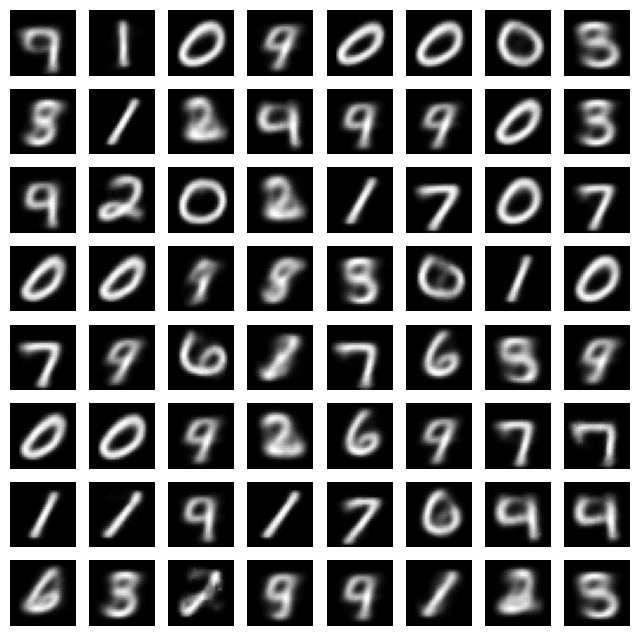

In [17]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decoder_pass(z)

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

# plt.show()
plt.savefig('cvae_mnist.webp')

In [18]:
# encode and plot the z values for the train set 
model.eval()
z_all = []
y_all = []
pred_y_all = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        mu, logvar, z, labels = model.half_pass(data)
        z_all.append(mu.cpu().numpy())
        y_all.append(np.argmax(target[:,0, 0:10].cpu().numpy(), axis=1))
        pred_y_all.append(np.argmax(labels[:, 0:10].cpu().numpy(), axis=1))

z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
pred_y_all = np.concatenate(pred_y_all, axis=0)

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

In [19]:
from collections import defaultdict

data_centroids_dict = defaultdict(list)

for mu, y in zip(z_all, pred_y_all):
    data_centroids_dict[y].append(mu)

cluster_centroids_from_data = []

for numb in range(0,10):
    cluster_centroids_from_data.append(np.mean(data_centroids_dict[numb], axis=0))


cluster_centroids_from_data

f:\Python38\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
f:\Python38\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[array([0.3651199 , 0.67505795], dtype=float32),
 array([ 0.14362273, -1.7206658 ], dtype=float32),
 array([-0.66177505,  0.07075863], dtype=float32),
 array([-1.1689221, -1.0114918], dtype=float32),
 array([-0.9205221 ,  0.94834924], dtype=float32),
 array([ 0.04062973, -0.4681907 ], dtype=float32),
 array([ 0.94150704, -0.79647976], dtype=float32),
 array([ 0.7391996 , -0.01332159], dtype=float32),
 array([ 1.3379774, -0.5586821], dtype=float32),
 nan]

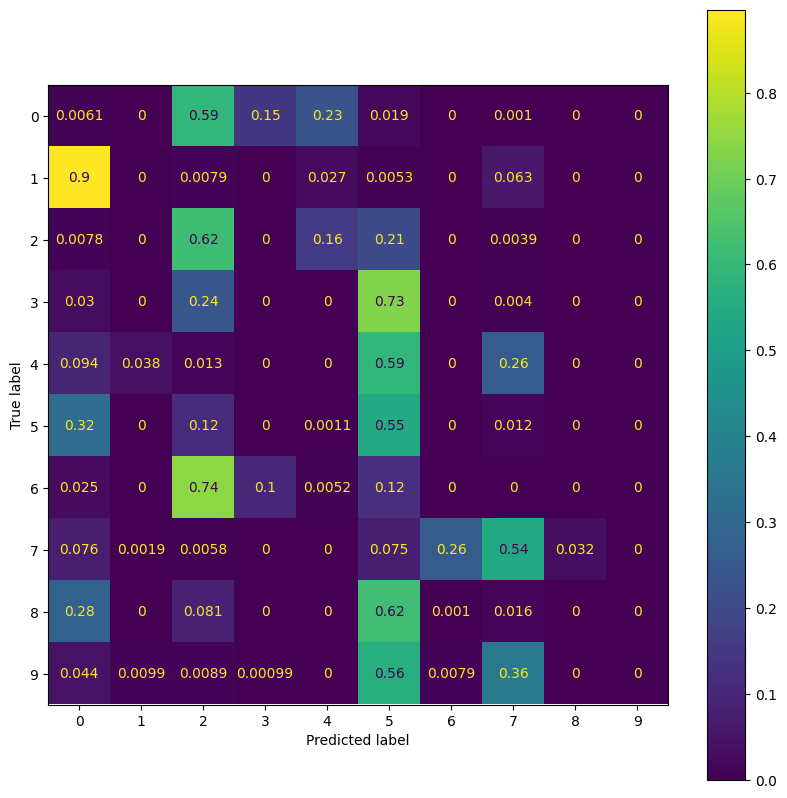

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_all, pred_y_all, normalize='true')
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize = (10, 10))
cmd.plot(ax=ax)

Text(0, 0.5, 'cvae 2')

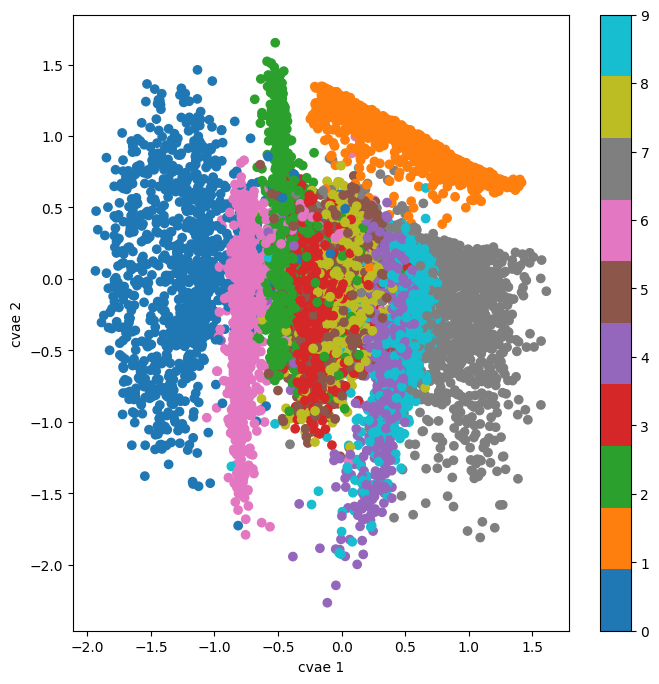

In [21]:
plt.figure(figsize=(8, 8))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
plt.colorbar()
plt.xlabel("cvae 1")
plt.ylabel("cvae 2")

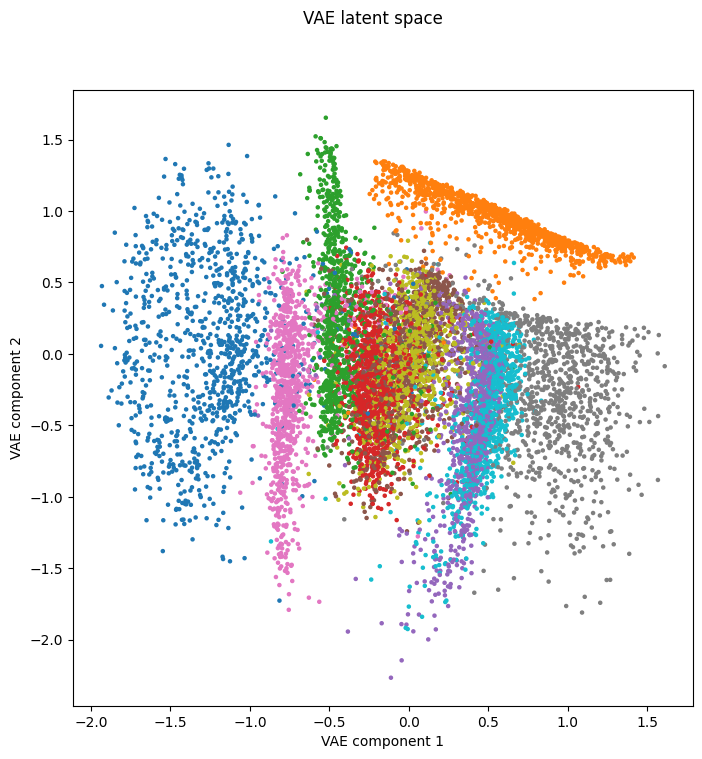

In [22]:
mask = "Fuzzy C-VAE"
if not is_fuzzy_loss_active:
    mask = "VAE"
import matplotlib.colors
# figure, axis = plt.subplots(2, 3, figsize=(17, 10)) 
# axis[0][0].scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10', s=8)
# axis[0][0].set_title("")
# axis[0][0].set_xlabel(f"{mask} component 1")
# axis[0][0].set_ylabel(f"{mask} component 2")


plt.figure(figsize=(8, 8))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10', s=5)
plt.xlabel(f"{mask} component 1")
plt.ylabel(f"{mask} component 2")
plt.suptitle(f'{mask} latent space')
if is_fuzzy_loss_active:
    plt.savefig('papers/iiti24/fig2b-fcvae-all-features.eps', format='eps')
else:
    plt.savefig('papers/iiti24/fig2a-vae-all-features.eps', format='eps')
plt.show()


In [23]:
domains_scatter_points = []
for x in np.linspace(-1.9, 2.0, 200):
    for y in np.linspace(-1.2, 2, 200):
        fuzzy_inference = model.fuzzy.forward(torch.FloatTensor([[x,y]]).to(device)).cpu().detach().numpy()
        fuzzy_class =np.argmax(fuzzy_inference[0,0:10])
        domains_scatter_points.append([x,y,fuzzy_class])

domains_scatter_points = np.array(domains_scatter_points)

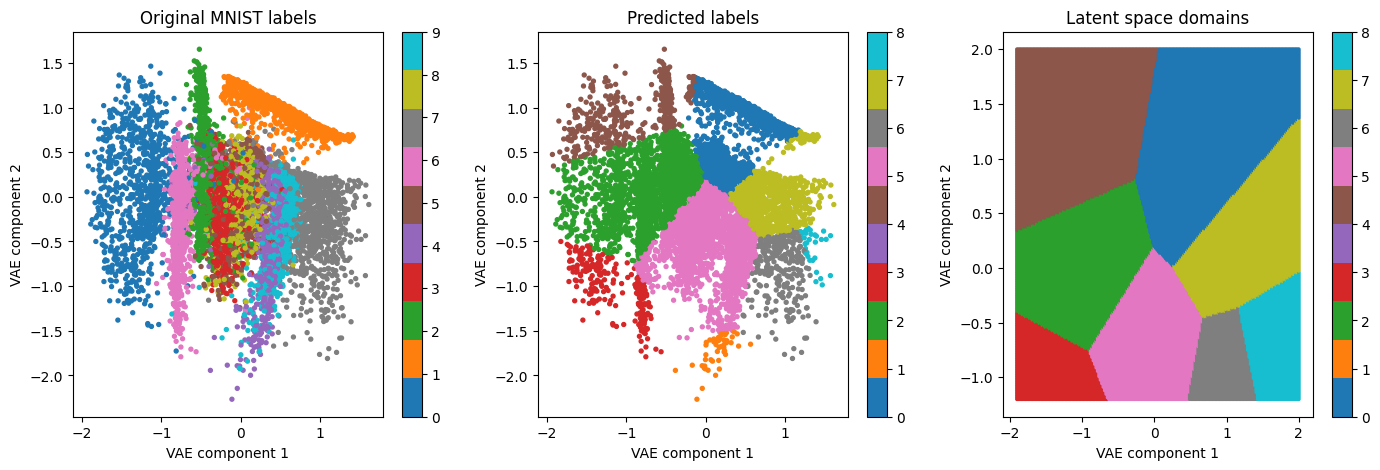

In [24]:
import matplotlib.colors
figure, axis = plt.subplots(1, 3, figsize=(17, 5)) 
sc1 =axis[0].scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10', s=8)
axis[0].set_title("Original MNIST labels")
axis[0].set_xlabel(f"{mask} component 1")
axis[0].set_ylabel(f"{mask} component 2")

sc2 = axis[1].scatter(z_all[:, 0], z_all[:, 1], c=pred_y_all, cmap='tab10', s=8)
axis[1].set_title("Predicted labels") 
axis[1].set_xlabel(f"{mask} component 1")
axis[1].set_ylabel(f"{mask} component 2")
tmm_cmap = matplotlib.colors.ListedColormap(['red', 'green'])

sc3 = axis[2].scatter(domains_scatter_points[:, 0], domains_scatter_points[:, 1], c = domains_scatter_points[:, 2], s=3, cmap='tab10')
axis[2].set_title("Latent space domains") 
axis[2].set_xlabel(f"{mask} component 1")
axis[2].set_ylabel(f"{mask} component 2")
figure.colorbar(sc1)
figure.colorbar(sc2)
figure.colorbar(sc3)

if is_fuzzy_loss_active:
    plt.savefig('papers/iiti24/fig3-fcvae-classification.eps', format="eps")
plt.show()

## Data generation

torch.Size([10, 2])


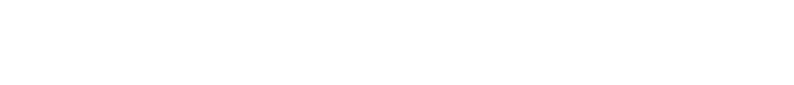

In [25]:
n = 10
path_from_4_to_9 = np.linspace(cluster_centroids_from_data[7], cluster_centroids_from_data[9], n)
path_from_4_to_9 = [torch.FloatTensor(a) for a in path_from_4_to_9]

z = torch.stack(path_from_4_to_9, dim=0).to(device)
print(z.shape)
samples = model.decoder_pass(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')
    
plt.savefig('papers/iiti24/fig4-sample-generation.eps', format="eps")
plt.show()


tensor([[-0.5091, -0.3160]], device='cuda:0', grad_fn=<SplitBackward>)
[[0.3 0.2 0.7 0.3 0.3 0.7 0.2 0.3 0.2 0.1]]


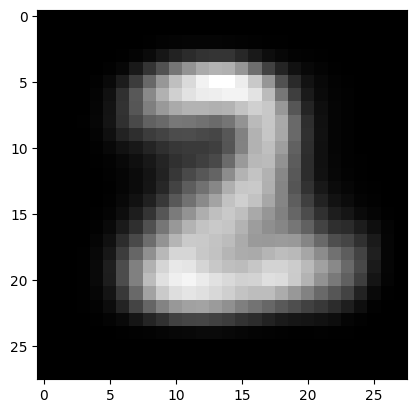

In [26]:

mu, std, z, fz = model.half_pass(test_data[1][0].reshape((1,1,28,28)).to(device))

# mu[0][0] = -2.8242958
# mu[0][1] = -0.39727297

print(mu)
np.set_printoptions(precision=1)
np.set_printoptions(suppress=True)
print(fz.cpu().detach().numpy())
samples = model.decoder_pass(mu)
#samples = torch.sigmoid(samples)
plt.imshow(samples[0].view(28, 28).cpu().detach().numpy(), cmap='gray')
    

## Anomaly detection

In [27]:
emnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [28]:
import pandas as pd

emnist_test = pd.read_csv("./data/EMNIST/emnist-letters.csv")
emnist_y = emnist_test["label"]
emnist_x = emnist_test.drop(labels = ["label"], axis = 1) 
del emnist_test 

emnist_x = emnist_x / 255.0
emnist_x = emnist_x.values.reshape(-1, 28, 28)
emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32) for a in emnist_x]

len(emnist_x)

C:\Users\Юрий\AppData\Local\Temp\ipykernel_20100\2301690307.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32) for a in emnist_x]


103600

In [29]:
emnist_mapping = pd.read_csv("./data/EMNIST/emnist-letters-mapping.txt", sep=' ', header=None)
emnist_mapping.columns=("EMNIST","UP","LO")
emnist_mapping["Letter"] = emnist_mapping.apply(lambda row: chr(row["UP"])+chr(row["LO"]), axis=1)
emnist_mapping = dict(zip(emnist_mapping["EMNIST"], emnist_mapping["Letter"]))
emnist_mapping

{1: 'Aa',
 2: 'Bb',
 3: 'Cc',
 4: 'Dd',
 5: 'Ee',
 6: 'Ff',
 7: 'Gg',
 8: 'Hh',
 9: 'Ii',
 10: 'Jj',
 11: 'Kk',
 12: 'Ll',
 13: 'Mm',
 14: 'Nn',
 15: 'Oo',
 16: 'Pp',
 17: 'Qq',
 18: 'Rr',
 19: 'Ss',
 20: 'Tt',
 21: 'Uu',
 22: 'Vv',
 23: 'Ww',
 24: 'Xx',
 25: 'Yy',
 26: 'Zz'}

In [30]:
model.eval()

anomaly_mu = defaultdict(list)


with torch.no_grad():
    for data, label in zip(emnist_x, emnist_y):
        data = data.view((-1,1,28,28)).to(device)
        mu, x_recon, flabels= model.forward(data)
        
        anomaly_mu[emnist_mapping[label]].append(mu.cpu().numpy())

anomaly_mu

defaultdict(list,
            {'Aa': [array([[-0.1, -0.6]], dtype=float32),
              array([[-0.4,  0.5]], dtype=float32),
              array([[-0.7, -0.9]], dtype=float32),
              array([[-1.4, -0.2]], dtype=float32),
              array([[ 0.2, -1.3]], dtype=float32),
              array([[-0.3,  0.1]], dtype=float32),
              array([[-0. , -0.9]], dtype=float32),
              array([[-0.1, -0.8]], dtype=float32),
              array([[-0.2, -1.1]], dtype=float32),
              array([[-0.4,  0.3]], dtype=float32),
              array([[-0.6,  0.6]], dtype=float32),
              array([[-0. , -0.9]], dtype=float32),
              array([[-1.6, -0.2]], dtype=float32),
              array([[-0.8, -0.1]], dtype=float32),
              array([[-0.4,  0.6]], dtype=float32),
              array([[-0.2, -0.8]], dtype=float32),
              array([[-0.1, -1.1]], dtype=float32),
              array([[-0.6,  0.4]], dtype=float32),
              array([[-0.2, -1.3]], dtyp

In [53]:
from sklearn.ensemble import IsolationForest

detectors = {}

if is_fuzzy_loss_active:
    for numb in range(0,10):
        isolf = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', max_features=1.0)
        isolf.fit(data_centroids_dict[numb])
        detectors[numb] = isolf
else:
    isolf = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', max_features=1.0)
    isolf.fit(z_all)
    detectors[0] = isolf

anomaly_rates = {}
for letters_pair in emnist_mapping.values():
   
    input = np.reshape(anomaly_mu[letters_pair],(len(anomaly_mu[letters_pair]),2))

    if is_fuzzy_loss_active:
        scores = [detectors[a].predict(input) for a in detectors.keys()]
        overall_score = np.max(scores,axis = 0)
        overall_score = [1 if a==-1 else 0 for a in overall_score]
        anomaly_rates[letters_pair] = (np.mean(overall_score), np.std(overall_score))
    else:
        scores = detectors[0].predict(input)
        overall_score = [1 if a==-1 else 0 for a in scores]
        anomaly_rates[letters_pair] = (np.mean(overall_score), np.std(overall_score))


In [54]:
scores = [detectors[a].predict(z_all) for a in detectors.keys()]

numbers_score = np.max(scores,axis = 0)
numbers_score = [1 if a==-1 else 0 for a in numbers_score]

print(f"Anomality rate on pure numbers {np.mean(numbers_score)}" )

Anomality rate on pure numbers 0.3151


In [55]:
anomaly_stats = []

anomaly_stats.append(
    {
            'Letters': '0123456789',
            'Detected anomaly rate': np.mean(numbers_score),
    }
)

for k in anomaly_rates.keys():
    anomaly_stats.append(
        {
            'Letters': k,
            'Detected anomaly rate': anomaly_rates[k][0],
        }
    )


pd.DataFrame(anomaly_stats).sort_values('Detected anomaly rate')

,Letters,Detected anomaly rate
13,Mm,0.007139
23,Ww,0.008764
25,Yy,0.079351
6,Ff,0.080830
16,Pp,0.111584
18,Rr,0.131548
21,Uu,0.142147
22,Vv,0.148451
20,Tt,0.157742
24,Xx,0.199302


In [56]:
latex_table = pd.DataFrame(anomaly_stats, index=None).sort_values('Detected anomaly rate').to_latex( escape = False,index=False, float_format="{:.2f}".format)
print(latex_table)

\begin{tabular}{lr}
\toprule
Letters & Detected anomaly rate \\
\midrule
Mm & 0.01 \\
Ww & 0.01 \\
Yy & 0.08 \\
Ff & 0.08 \\
Pp & 0.11 \\
Rr & 0.13 \\
Uu & 0.14 \\
Vv & 0.15 \\
Tt & 0.16 \\
Xx & 0.20 \\
Hh & 0.23 \\
Nn & 0.24 \\
Ii & 0.24 \\
Kk & 0.29 \\
0123456789 & 0.32 \\
Ll & 0.33 \\
Jj & 0.42 \\
Aa & 0.47 \\
Gg & 0.54 \\
Ee & 0.55 \\
Bb & 0.61 \\
Qq & 0.61 \\
Ss & 0.63 \\
Dd & 0.64 \\
Zz & 0.79 \\
Cc & 0.83 \\
Oo & 0.91 \\
\bottomrule
\end{tabular}



tensor([0.3097, 0.2051, 0.5315, 0.3188, 0.2251, 0.8330, 0.2817, 0.3149, 0.2397,
        0.1616], device='cuda:0')
tensor(0.8330, device='cuda:0')


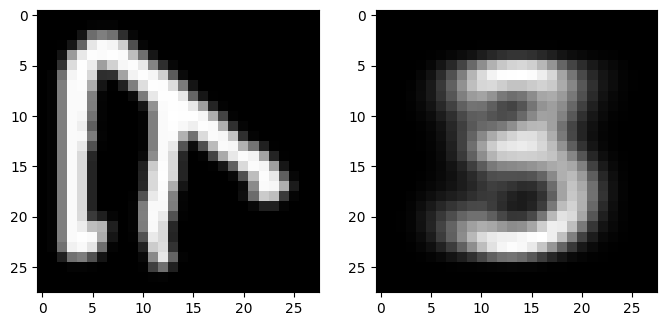

In [45]:
model.eval()

with torch.no_grad():
    fig, ax = plt.subplots(1, 2, figsize=(8, 8))
    data = emnist_x[4009]
    data = data.view((-1,1,28,28)).to(device)
    mu, x_recon, flabels= model.forward(data)
    print(flabels[0])
    print(flabels[0][0:10].max())
    ax[0].imshow(data.view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[1].imshow(x_recon.view(28, 28).cpu().detach().numpy(), cmap='gray')